<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/feature%2Fdata-augmentation-Hyun/data_agumentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기존 데이터(1week)를 가지고 1개주기(4months) 로 증강
- 마지막 부분의 데이터의 bar 가 18까지 증가하도록 적용

Original Data:
                 Time  conductivity  feed_pressure
0 2024-10-07 16:30:21       21.6875       6.463125
1 2024-10-07 16:31:21       17.3125       8.120625
2 2024-10-07 16:32:21        6.6875       8.595000
3 2024-10-07 16:33:21        7.5000       8.651250
4 2024-10-07 16:34:21        8.4375       8.658750

Expanded Data:
                 Time  conductivity  feed_pressure
0 2024-06-22 21:21:00     21.687500       6.463125
1 2024-06-22 21:22:00     21.414085       6.566747
2 2024-06-22 21:23:00     21.140671       6.670368
3 2024-06-22 21:24:00     20.867256       6.773990
4 2024-06-22 21:25:00     20.593842       6.877611


<ipython-input-3-b482da3ac572>:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_new = pd.date_range(start=time_min, periods=len(df_selected) * 16, freq='T')


Expanded data saved to one-cycle-4months.xlsx


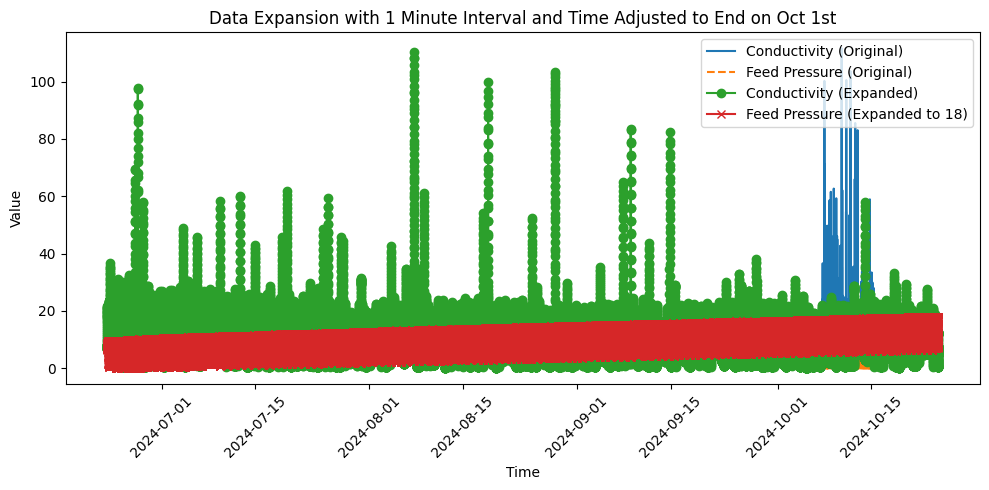

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d

# CSV 파일 불러오기 및 처리
file_name = '2차 통합운전데이터(1007_).CSV'
df = pd.read_csv(file_name)

# E열 (처리수 전기전도도), K열 (RO유입압력) 추출
df_selected = df[['Time', 'Permeate Conductivity', 'Feed Pressure']]
df_selected.columns = ['Time', 'conductivity', 'feed_pressure']

# Time 컬럼을 datetime 형태로 변환
df_selected['Time'] = pd.to_datetime(df_selected['Time'])

# 데이터 확인
print("Original Data:")
print(df_selected.head())

# 경향성을 기반으로 데이터를 16배로 늘리기
# 1. 시간 간격을 1분으로 설정하며 시간 데이터를 16배로 확장
time_min = df_selected['Time'].min()

# 데이터 길이가 1주일이므로, 전체 데이터의 길이를 16배로 늘림(4개월)
time_new = pd.date_range(start=time_min, periods=len(df_selected) * 16, freq='T')

# 2. 각 특성 데이터를 선형보간
conductivity_interp = interp1d(np.arange(len(df_selected)), df_selected['conductivity'], kind='linear')
feed_pressure_interp = interp1d(np.arange(len(df_selected)), df_selected['feed_pressure'], kind='linear')

# 새로운 시간에 맞춰 데이터를 16배로 늘림
x_new = np.linspace(0, len(df_selected) - 1, len(df_selected) * 16)
conductivity_new = conductivity_interp(x_new)
feed_pressure_new = feed_pressure_interp(x_new)

# 3. feed_pressure 데이터를 점진적으로 18에 가깝게 증가시키기 위한 처리
# feed_pressure 값이 점점 증가하여 18에 수렴하도록 비율을 적용
target_value = 18
current_max = feed_pressure_new.max()
feed_pressure_new = feed_pressure_new + (target_value - current_max) * (np.linspace(0, 1, len(feed_pressure_new)))

# 확장된 데이터를 새로운 데이터프레임에 저장
df_expanded = pd.DataFrame({
    'Time': time_new,
    'conductivity': conductivity_new,
    'feed_pressure': feed_pressure_new
})

# 마지막 시간을 10월 25일로 맞추기 위한 처리
time_difference = pd.to_datetime('2024-10-25') - df_expanded['Time'].iloc[-1]
df_expanded['Time'] = df_expanded['Time'] + time_difference

# 결과 확인
print("\nExpanded Data:")
print(df_expanded.head())

# 증강된 데이터를 엑셀 파일로 저장
output_file = 'one-cycle-4months.xlsx'
df_expanded.to_excel(output_file, index=False)
print(f"Expanded data saved to {output_file}")

# 데이터 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_selected['Time'], df_selected['conductivity'], label='Conductivity (Original)')
plt.plot(df_selected['Time'], df_selected['feed_pressure'], label='Feed Pressure (Original)', linestyle='--')

plt.plot(df_expanded['Time'], df_expanded['conductivity'], label='Conductivity (Expanded)', marker='o')
plt.plot(df_expanded['Time'], df_expanded['feed_pressure'], label='Feed Pressure (Expanded to 18)', marker='x')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Data Expansion with 1 Minute Interval and Time Adjusted to End on Oct 1st')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1년 6개월 치 데이터 증강(16months)
- 위에서 생성한 1개주기(4months) 를 4배로 증강하여 앞쪽에 추가한 것


Final Data with 3 Copies Added:
                 Time  conductivity  feed_pressure
0 2024-02-19 18:41:00     21.687500       6.463125
1 2024-02-19 18:42:00     21.414085       6.566747
2 2024-02-19 18:43:00     21.140671       6.670368
3 2024-02-19 18:44:00     20.867256       6.773990
4 2024-02-19 18:45:00     20.593842       6.877611
Final data with copies saved to four-cycle-16months.xlsx


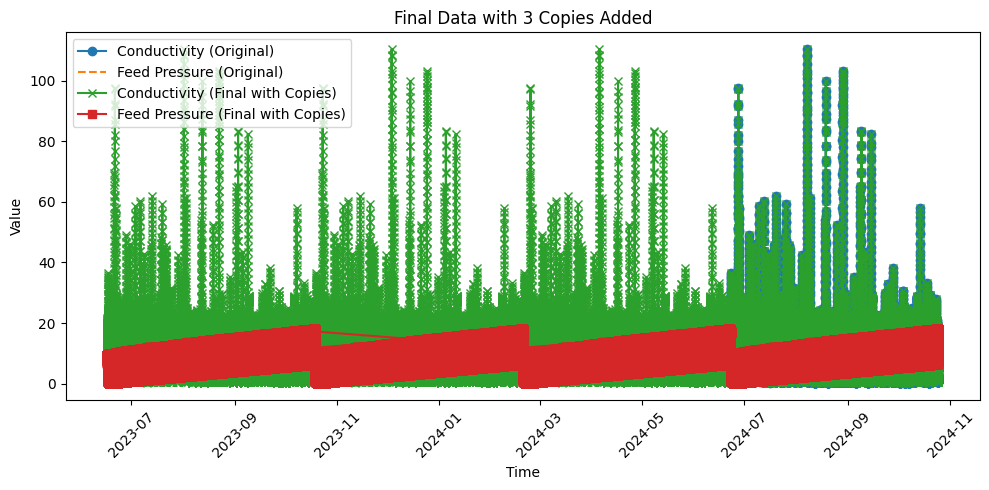

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 이전에 생성한 엑셀 파일 불러오기
file_name = 'one-cycle-4months.xlsx'
df_expanded = pd.read_excel(file_name)

# 증강된 데이터를 3번 복사하여 앞에 추가
num_copies = 3
augmented_data_list = []

for i in range(1, num_copies + 1):
    temp_data = df_expanded.copy()
    # Time 데이터를 각 복사본마다 1분씩 감소
    temp_data['Time'] = temp_data['Time'] - pd.to_timedelta(i * len(df_expanded), unit='m')
    augmented_data_list.append(temp_data)

# 복사된 데이터를 기존 데이터 앞에 붙이기
df_final = pd.concat(augmented_data_list + [df_expanded]).reset_index(drop=True)

# 결과 확인
print("\nFinal Data with 3 Copies Added:")
print(df_final.head())

# 최종 데이터를 엑셀 파일로 저장
output_file = 'four-cycle-16months.xlsx'
df_final.to_excel(output_file, index=False)
print(f"Final data with copies saved to {output_file}")

# 데이터 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_expanded['Time'], df_expanded['conductivity'], label='Conductivity (Original)', marker='o')
plt.plot(df_expanded['Time'], df_expanded['feed_pressure'], label='Feed Pressure (Original)', linestyle='--')

plt.plot(df_final['Time'], df_final['conductivity'], label='Conductivity (Final with Copies)', marker='x')
plt.plot(df_final['Time'], df_final['feed_pressure'], label='Feed Pressure (Final with Copies)', marker='s')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Final Data with 3 Copies Added')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
